In [1]:
!pip install wandb


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import wandb
wandb.login()
wandb.login(key="acdc26d2fc17a56e83ea3ae6c10e496128dee648")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: viinod9 (viinod9-iitm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/vinodkumar/.netrc


True

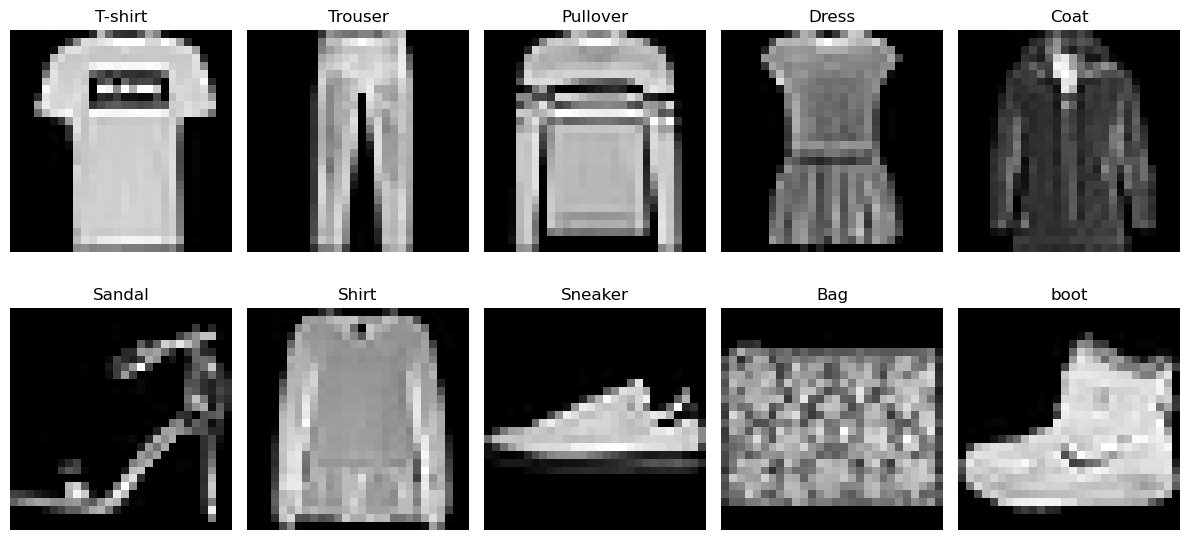

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist , mnist
from sklearn.model_selection import train_test_split
import argparse

# wandb.init(project="DL_assignment_1", name = "Question 1")

# Load the Fashion-MNIST dataset
(x_train, y_train), (x_test,y_test) = fashion_mnist.load_data()


# Define class labels
class_labels = {
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'boot'
}

# Plot one sample image for each class
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

for i in range(10):
    # Find the first image of current class
    idx = np.where(y_train == i)[0][0]
    # Plot the image
    axes[i].imshow(x_train[idx], cmap='gray')
    axes[i].set_title(class_labels[i])
    axes[i].axis('off')
    # wandb.log({"Question 1": [wandb.Image(axes[i], caption=y_train[i])]})

plt.tight_layout()
plt.show()
# wandb.finish()

#x_train.shape

### Question -2 

In [8]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ NEURAL NETWORK ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
class NeuralNet:
  def __init__(self, par):

    #defining required paramters within this class
    self.layer_data = {}
    self.epoch = par['epochs']
    self.hiddenlayers = par['hidden_layers']
    self.hiddenlayer_size = par['hidden_layer_size']
    self.inputSize = par['input_size']
    self.outputSize = par['output_size']
    self.eta = par['learning_rate']
    self.beta = par['beta']
    self.momentum = par['momentum']
    self.beta1 = par['beta1']
    self.beta2 = par['beta2']
    self.epsilon = par['epsilon']
    self.optimizer = par['optimizer']
    self.batch = par['batch_size']
    self.activation = par['activation']
    self.initialiser = par['initialiser']
    self.weight_decay = par['weight_decay']
    self.loss_type = par['loss_type']
    self.a = {}
    self.h = {}
    self.dw = {}
    self.db = {}

    L = self.hiddenlayers + 1 # 1- input L - hidden 1 - output
    self.layer_data[1] = weightsAndBiasLayer(self.inputSize,self.hiddenlayer_size,self.initialiser)

    for i in range(2 , L):
      self.layer_data[i] = weightsAndBiasLayer(self.hiddenlayer_size,self.hiddenlayer_size,self.initialiser)

    self.layer_data[L] = weightsAndBiasLayer(self.hiddenlayer_size,self.outputSize,self.initialiser)


#------------------------------------ forward propagation---------------------------------------------------


  def forwardpropagate(self,x):

    self.h[0] = x
    L  = len(self.layer_data)
    for i in range(1, L):
      self.a[i] = self.layer_data[i].forwarding(self.h[i-1])
      self.h[i] = self.layer_data[i].activation_function(self.activation, self.a[i])
    self.a[L] = self.layer_data[L].forwarding(self.h[L-1])
    y_pred = self.layer_data[L].activation_function('softmax',self.a[L])
    return y_pred


#------------------------------------backward propagation---------------------------------------------------

  def backwardpropagate(self, y_pred, y_true):

    L = len(self.layer_data)
    n = len(y_pred)

    #handling output loss for MSE and CE

    if self.loss_type == 'cross_entropy':
      op_error = y_pred - y_true

    if self.loss_type == 'mean_squared_error':
      op_error = (y_pred - y_true)*self.layer_data[L].diff_function('softmax',self.a[L]) / (y_pred.shape[0])

    for i in range(L, 1, -1):
      self.dw[i] = np.dot(self.h[i-1].T,op_error) /n
      self.db[i] = np.sum(op_error, axis=0, keepdims=True)/n

      grad_layer = np.dot(op_error , self.layer_data[i].weights.T)
      op_error = grad_layer * self.layer_data[i-1].diff_function(self.activation,self.a[i-1])

    # 1
    self.dw[1] = np.dot(self.h[0].T,op_error)/n
    self.db[1] = np.sum(op_error, axis=0, keepdims=True)/n



# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ LAYER CLASS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
class weightsAndBiasLayer:


#------------------------------------weight initialisation method---------------------------------------------------

  def __init__(self,lowlayer,upperlayer,initialiser):

    if(initialiser == 'random'):
      self.weights = np.random.randn(lowlayer,upperlayer)
      self.bias = np.random.randn(1,upperlayer)
    if(initialiser == 'Xavier'):
      variance = 6.0 / (lowlayer + upperlayer)
      stddev = np.sqrt(variance)
      self.weights = np.random.randn(lowlayer,upperlayer)*stddev
      self.bias = np.random.randn(1,upperlayer)*stddev

  def forwarding(self,x):
    return np.dot(x,self.weights) + self.bias

#----------------------------------------------Activation funciton-------------------------------------

  def activation_function(self,func_type,x):
    if(func_type == 'sigmoid'):
      return self.sigmoid(x)
    elif(func_type == 'softmax'):
      return self.softmax(x)
    if(func_type == 'tanh'):
      return self.tanh(x)
    if(func_type == 'ReLU'):
      return self.reLu(x)
    if(func_type == 'identity'):
      return self.identity


  def sigmoid(self,input):

    return 1.0/(1.0 + np.exp(-input))

  def softmax(self,x):
    exp_vals = np.exp(x - np.max(x, axis=-1 , keepdims = True))
    softmax_vals = exp_vals / np.sum(exp_vals, axis=-1 , keepdims = True)
    return softmax_vals

  def tanh(self,x):

    tan_res =np.tanh(x)
    return tan_res

  def reLu(self,x):

    return np.maximum(0,x)

  def identity(self,x):
    return x

#-----------------------------------------------Diffrentiation of activation funcitons------------------------------------
  def diff_function(self,func_type,x):
    if(func_type == 'sigmoid'):
      return self.diff_sig(x)
    if(func_type == 'tanh'):
      return self.diff_tanh(x)
    if(func_type == 'ReLU'):
      return self.diff_reLu(x)
    if(func_type == 'identity'):
      return self.diff_identity(x)
    if(func_type == 'softmax'):
      return self.diff_softmax(x)

  def diff_sig(self, x):
    func = self.sigmoid(x)
    return func*(1-func)

  def diff_tanh(self,x):
    func = self.tanh(x)
    return 1 - func**2

  def diff_reLu(self,x):
    return np.where(x <= 0, 0, 1)

  def diff_identity(self,x):
    return np.ones(x.shape)

  def diff_softmax(self,x):
      g = self.softmax(x)
      return g * (1 - g)

#------------------------------------------optimisation functions-----------------------------------------
class optimisation_functions:

  def __init__(self,neural_net,opt_func,eta_par,beta_par,momentum_par,epsilon,beta1,beta2,weight_decay):
    self.opt_type = opt_func
    self.neural_net = neural_net
    self.eta = eta_par
    self.beta = beta_par
    self.momentum = momentum_par
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    self.decay = weight_decay
    self.u_wt = {}
    self.u_b = {}
    self.vw = {}
    self.vb = {}
    self.mw = {}
    self.mb = {}
    self.mcap_w = {}
    self.mcap_b = {}
    self.vcap_w = {}
    self.vcap_b = {}
    self.mform_w = {}
    self.mform_b = {}
    self.t = 1


  def update_rule(self):
    if(self.opt_type == 'sgd'):
      self.sgd()
    if(self.opt_type == 'mgd'):
      self.mgd()
    if(self.opt_type == 'nag'):
      self.nag()
    if(self.opt_type == 'rmsprop'):
      self.rms_prop()
    if(self.opt_type == 'adam'):
      self.adam()
    if(self.opt_type == 'nadam'):
      self.nadam()


  def sgd(self):

    for i in range(1, len(self.neural_net.layer_data) + 1):
      self.neural_net.dw[i] += self.neural_net.layer_data[i].weights*self.decay
      self.neural_net.layer_data[i].weights -= (self.eta*self.neural_net.dw[i])
      self.neural_net.layer_data[i].bias -= (self.eta*self.neural_net.db[i])

  def mgd(self):
    if(len(self.u_wt)  == 0 ):
      self.u_wt = self.neural_net.dw
      self.u_b = self.neural_net.db

    for i in range(1,len(self.neural_net.layer_data)+1):

      self.neural_net.dw[i] += self.neural_net.layer_data[i].weights*self.decay
      self.u_wt[i] = self.momentum * self.u_wt[i] + self.neural_net.dw[i]
      self.u_b[i] = self.momentum * self.u_b[i] + self.neural_net.db[i]
      self.neural_net.layer_data[i].weights -= self.eta*self.u_wt[i]
      self.neural_net.layer_data[i].bias -= self.eta*self.u_b[i]

  def nag(self):
# this formation of Nag was taken from later slides(Sir's slides) to avoid calculating grad(w-vw)
    if(len(self.vw )== 0):
      for i in range(1,len(self.neural_net.layer_data)+1):

        self.vw[i] = np.zeros(self.neural_net.dw[i].shape)
        self.vb[i] = np.zeros(self.neural_net.db[i].shape)

    for i in range(1,len(self.neural_net.layer_data)+1):

      self.neural_net.dw[i] += self.neural_net.layer_data[i].weights*self.decay
      self.vw[i] = self.beta * self.vw[i] + self.neural_net.dw[i]
      self.vb[i] = self.beta * self.vb[i] + self.neural_net.db[i]

      self.neural_net.layer_data[i].weights -= self.eta*(self.vw[i] + self.neural_net.dw[i])
      self.neural_net.layer_data[i].bias -= self.eta*(self.vb[i] + self.neural_net.db[i])

  def rms_prop(self):

    if(len(self.vw )== 0):
      for i in range(1,len(self.neural_net.layer_data)+1):

        self.vw[i] = (self.neural_net.dw[i]**2)
        self.vb[i] = (self.neural_net.db[i]**2)

    for i in range(1,len(self.neural_net.layer_data)+1):

      self.neural_net.dw[i] += self.neural_net.layer_data[i].weights*self.decay

      self.vw[i] = self.beta * self.vw[i] + (1 - self.beta)*(self.neural_net.dw[i]**2)
      self.vb[i] = self.beta * self.vb[i] + (1 - self.beta)*(self.neural_net.db[i]**2)

      self.neural_net.layer_data[i].weights -= (self.eta/np.sqrt(self.vw[i] + self.epsilon))*(self.vw[i] + self.neural_net.dw[i])
      self.neural_net.layer_data[i].bias -= (self.eta/np.sqrt(self.vb[i] + self.epsilon))*(self.vb[i] + self.neural_net.db[i])

  def adam(self):

    if(len(self.vw )== 0):
      for i in range(1,len(self.neural_net.layer_data)+1):

        self.vw[i] = (self.neural_net.dw[i]**2)
        self.vb[i] = (self.neural_net.db[i]**2)

    if(len(self.mw )== 0):
      for i in range(1,len(self.neural_net.layer_data)+1):

        self.mw[i] = (self.neural_net.dw[i])
        self.mb[i] = (self.neural_net.db[i])

    for i in range(1,len(self.neural_net.layer_data)+1):

      self.neural_net.dw[i] += self.neural_net.layer_data[i].weights*self.decay

      self.mw[i] = self.beta1 * self.mw[i] + (1 - self.beta1)*(self.neural_net.dw[i])
      self.mb[i] = self.beta1 * self.mb[i] + (1 - self.beta1)*(self.neural_net.db[i])

      self.mcap_w[i] = self.mw[i] / (1 - self.beta1**self.t)
      self.mcap_b[i] = self.mb[i] / (1 - self.beta1**self.t)

      self.vw[i] = self.beta2 * self.vw[i] + (1 - self.beta2)*(self.neural_net.dw[i]**2)
      self.vb[i] = self.beta2 * self.vb[i] + (1 - self.beta2)*(self.neural_net.db[i]**2)

      self.vcap_w[i] = self.vw[i] / (1 - self.beta2**self.t)
      self.vcap_b[i] = self.vb[i] / (1 - self.beta2**self.t)

      self.neural_net.layer_data[i].weights -= (self.eta/np.sqrt(self.vcap_w[i] + self.epsilon))*(self.mcap_w[i])
      self.neural_net.layer_data[i].bias -= (self.eta/np.sqrt(self.vcap_b[i] + self.epsilon))*(self.mcap_b[i])

    self.t += 1

  def nadam(self):

    if(len(self.vw )== 0):
      for i in range(1,len(self.neural_net.layer_data)+1):

        self.vw[i] = (self.neural_net.dw[i]**2)
        self.vb[i] = (self.neural_net.db[i]**2)

    if(len(self.mw )== 0):
      for i in range(1,len(self.neural_net.layer_data)+1):

        self.mw[i] = (self.neural_net.dw[i])
        self.mb[i] = (self.neural_net.db[i])

    for i in range(1,len(self.neural_net.layer_data)+1):

      self.neural_net.dw[i] += self.neural_net.layer_data[i].weights*self.decay

      self.mw[i] = self.beta1 * self.mw[i] + (1 - self.beta1)*(self.neural_net.dw[i])
      self.mb[i] = self.beta1 * self.mb[i] + (1 - self.beta1)*(self.neural_net.db[i])

      self.mcap_w[i] = self.mw[i] / (1 - self.beta1**self.t)
      self.mcap_b[i] = self.mb[i] / (1 - self.beta1**self.t)

      self.vw[i] = self.beta2 * self.vw[i] + (1 - self.beta2)*(self.neural_net.dw[i]**2)
      self.vb[i] = self.beta2 * self.vb[i] + (1 - self.beta2)*(self.neural_net.db[i]**2)

      self.vcap_w[i] = self.vw[i] / (1 - self.beta2**self.t)
      self.vcap_b[i] = self.vb[i] / (1 - self.beta2**self.t)

      self.mform_w[i] = self.beta1 * self.mcap_w[i] + (1 - self.beta1)*self.neural_net.dw[i]
      self.mform_b[i] = self.beta1 * self.mcap_b[i] + (1 - self.beta1)*self.neural_net.db[i]

      self.neural_net.layer_data[i].weights -= (self.eta/np.sqrt(self.vcap_w[i] + self.epsilon))*(self.mform_w[i])
      self.neural_net.layer_data[i].bias -= (self.eta/np.sqrt(self.vcap_b[i] + self.epsilon))*(self.mform_b[i])

    self.t += 1



#============================================Super Neural (Calls and trains the entire Neural Network)=================================================


class super_neural:

  def __init__(self,parameters,X_train, Y_train, X_test, Y_test,x_val , y_val):
    self.nn = NeuralNet(parameters)
    self.opt_call = opt_call = optimisation_functions(self.nn,self.nn.optimizer,self.nn.eta,self.nn.beta,self.nn.momentum,self.nn.epsilon,self.nn.beta1,self.nn.beta2,self.nn.weight_decay)
    self.train_neural(X_train, Y_train, X_test, Y_test , x_val , y_val)


  def cross_entropy(self, y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1. - 1e-15)
    loss = -np.sum(y_true * np.log(y_pred), axis=1)
    loss = np.mean(loss)
    return loss

  def mean_squared_error(self,true_values, predicted_values):

    squared_errors = 0.5*(true_values - predicted_values) ** 2
    mean_squared_error = np.mean(squared_errors)

    return mean_squared_error


  def accuracy(self,y_true ,y_pred):
    pred = np.argmax(y_pred, axis=1)
    true = np.argmax(y_true, axis=1)
    predict = np.sum(pred == true)
    return (predict/len(pred))*100


  def loss_call(self,y_true, y_pred):
    if( self.nn.loss_type == 'mean_squared_error'):
      return self.mean_squared_error(y_true, y_pred)
    if( self.nn.loss_type == 'cross_entropy'):
      return self.cross_entropy(y_true, y_pred)


# funciton which plots a confusion matrix

  def plot_confusion_matrix(self,true_labels, predicted_labels):

    classes = ['T-shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','boot']
    # Compute confusion matrix
    true_labels = np.argmax(true_labels, axis=1)
    predicted_labels = np.argmax(predicted_labels, axis=1)
    num_classes = len(classes)
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    for i in range(len(true_labels)):
        true_class = true_labels[i]
        predicted_class = predicted_labels[i]
        confusion_matrix[int(true_class)][int(predicted_class)] += 1

    # Plot confusion matrix
    plt.figure(figsize=(9, 11))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap="turbo")
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = confusion_matrix.max() / 2.
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, format(confusion_matrix[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if confusion_matrix[i, j] > thresh else "white")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    wandb.init(project="DL_assignment_1",id="confusion_matrix")
    images = wandb.Image(plt)
    wandb.log({"confusion_matrix":images})
    plt.show()


#------------------------------------trians the network with customized batch sizes---------------------------------------------------


  def train_neural(self, X_train, Y_train , X_test ,Y_test,x_val , y_val):

    for epochit in range(self.nn.epoch):

      for batch_beg in range(0,len(X_train),self.nn.batch):

        batch_end = batch_beg+self.nn.batch
        input_data = X_train[batch_beg:batch_end]
        output_data = Y_train[batch_beg:batch_end]

        y_pred = self.nn.forwardpropagate(input_data)

        self.nn.backwardpropagate(y_pred, output_data)
        self.opt_call.update_rule()

      y_pred = self.nn.forwardpropagate(X_train)
      y_pred_test = self.nn.forwardpropagate(X_test)
      y_pred_val = self.nn.forwardpropagate(x_val)
      print(f"Epoch : {epochit + 1} Loss : {self.loss_call(Y_train, y_pred)} Accuracy : {self.accuracy(Y_train, y_pred)}")
      print("------------------------------------------------------------------------------------------------------------------------------")
      print(f"            Validation  Loss : {self.loss_call(y_val, y_pred_val)} Accuracy : {self.accuracy(y_val, y_pred_val)}")
      print("===============================================================================================================================")
      wandb.log({'epoch':epochit + 1, 'train_loss': self.loss_call(Y_train, y_pred), 'train_accuracy': self.accuracy(Y_train, y_pred), 'val_loss': self.cross_entropy(y_val, y_pred_val), 'val_accuracy': self.accuracy(y_val, y_pred_val)})



In [10]:
#------------------------------------Defines sweep configs for Wandb plotting---------------------------------------------------



sweep_config = {
    'name' : "sweep_final_MNIST",
    'method': 'grid'
    }

parameters_sweep = {
  'epochs' : {'values' : [10] } , #5, number of epochs ,15
  'hidden_layers' : {'values' : [5] } , #4, hidden layers neuron count and number of hidden layers
  'hidden_layer_size' : {'values' : [128] } ,#32,64,
  'input_size' : {'values' : [784] } ,
  'output_size' : {'values' : [10] } ,
  'learning_rate' : {'values' : [0.0001] } , #0.0005, eta
  'momentum' : {'values' : [0.009]}, #,0.5 beta for momentum
  'beta' : {'values' : [0.9] } ,  #,0.5 beta for rms
  'beta1' : {'values' : [0.9] }, #,0.999
  'beta2' : {'values' : [0.999] },
  'epsilon' : {'values' : [1e-6] },#1e-8,
  'optimizer' : {'values' : ['adam','nadam'] }, #'mgd','sgd','nag','rmsprop',,'adam' type of optimizer such as sgd,nadam,nag,
  'batch_size' : {'values' : [32] }, #16,32,32,,128
  'initialiser' : {'values' : ['Xavier'] }, #,'random' random,Xavier
  'activation' : {'values' : ['ReLU'] }, #'sigmoid','tanh', type of actvation
  'weight_decay' : {'values' : [1e-6,0]}, #0.0,
  'loss_type' : {'values' : ['cross_entropy']}, #,'mean_squared_error', 'cross_entropy'
  'dataset' : {'values' : ['mnist']} #mnist
  }


metric = {
    'name' : 'Accuracy',
    'goal' : 'maximize'
}

sweep_config['metric'] = metric

sweep_config['parameters'] = parameters_sweep

In [12]:
#------------------------------------Loads the type of dataset needed---------------------------------------------------

def dataset_selector(dataset):
  if(dataset == 'mnist'):
      (x_train, y_train), (x_test,y_test) = mnist.load_data()
      x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
  else:
    (x_train, y_train), (x_test,y_test) = fashion_mnist.load_data()
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

  return x_train,y_train,x_val,y_val

In [14]:
def main():
    def reshape_1D(data):
      return data.reshape(data.shape[0],-1)/255.0

    def one_hot_vector(y):
      hot_vectors = np.zeros((len(y), 10))  # Initialize array with zeros
      hot_vectors[np.arange(len(y)), y] = 1  # Set the corresponding index to 1 for each one-hot vector
      return hot_vectors

    param = wandb.init(project="DL_assignment_1")
    wandb.run.name = (
        ":ep-" + str(param.config.epochs) +
        ":h-" + str(param.config.hidden_layers) +
        ":bs-" + str(param.config.batch_size) +
        ":opt-" + param.config.optimizer +
        ":a-" + param.config.activation +
        ":wi-" + param.config.initialiser +
        ":d-" + str(param.config.weight_decay) +
        ":eta-" + str(param.config.learning_rate) +
        ":b-" + str( param.config.beta)
    )
    parameters = {
      'epochs' : param.config.epochs, #number of epochs
      'hidden_layers' : param.config.hidden_layers, #hidden layers neuron count and number of hidden layers
      'hidden_layer_size' : param.config.hidden_layer_size,
      'input_size' : param.config.input_size,
      'output_size' : param.config.output_size,
      'learning_rate' : param.config.learning_rate, #eta
      'momentum' : param.config.momentum,
      'beta' : param.config.beta,  #beta
      'beta1' : param.config.beta1,
      'beta2' : param.config.beta2,
      'epsilon' : param.config.epsilon,
      'optimizer' : param.config.optimizer, #type of optimizer such as sgd,nadam,nag,
      'batch_size' : param.config.batch_size, #16,32
      'initialiser' : param.config.initialiser, #random,Xavier
      'activation' : param.config.activation, #type of actvation
      'weight_decay' : param.config.weight_decay,
      'loss_type' : param.config.loss_type,
      'dataset' : param.config.dataset,
      }



#data preprocessing and dataset selection

    x_train,y_train,x_val,y_val = dataset_selector(parameters['dataset'])

    X_train = reshape_1D(x_train)
    Y_train = one_hot_vector(y_train)
    X_test = reshape_1D(x_test)
    Y_test = one_hot_vector(y_test)
    X_val = reshape_1D(x_val)
    Y_val = one_hot_vector(y_val)

#model creation for the neural network and generating logs for accuracy along with confusion matrix

    model = super_neural(parameters,X_train, Y_train, X_test, Y_test,X_val , Y_val)
    y_pred_val = model.nn.forwardpropagate(X_val)
    y_pred_test = model.nn.forwardpropagate(X_test)
    acc_val = model.accuracy(y_pred_val , Y_val)
    acc_test = model.accuracy(y_pred_test , Y_test)
    wandb.log({'Accuracy': acc_val})
    model.plot_confusion_matrix(y_pred_test,Y_test)

Create sweep with ID: ra3jcrfd
Sweep URL: https://wandb.ai/viinod9-iitm/DL_assignment_1/sweeps/ra3jcrfd


wandb: Agent Starting Run: aqbpalyl with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: mnist
wandb: 	epochs: 10
wandb: 	epsilon: 1e-06
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	initialiser: Xavier
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: cross_entropy
wandb: 	momentum: 0.009
wandb: 	optimizer: adam
wandb: 	output_size: 10
wandb: 	weight_decay: 1e-06


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch : 1 Loss : 0.3127358623162913 Accuracy : 90.48148148148148
------------------------------------------------------------------------------------------------------------------------------
            Validation  Loss : 0.313174230052705 Accuracy : 90.45
Epoch : 2 Loss : 0.1960056503369716 Accuracy : 94.08333333333333
------------------------------------------------------------------------------------------------------------------------------
            Validation  Loss : 0.21004057040083543 Accuracy : 93.71666666666667
Epoch : 3 Loss : 0.14203281704729373 Accuracy : 95.8037037037037
------------------------------------------------------------------------------------------------------------------------------
            Validation  Loss : 0.16850423546185422 Accuracy : 95.03333333333333
Epoch : 4 Loss : 0.11029869498317717 Accuracy : 96.74259259259259
---------------------------------------------------------------------------------

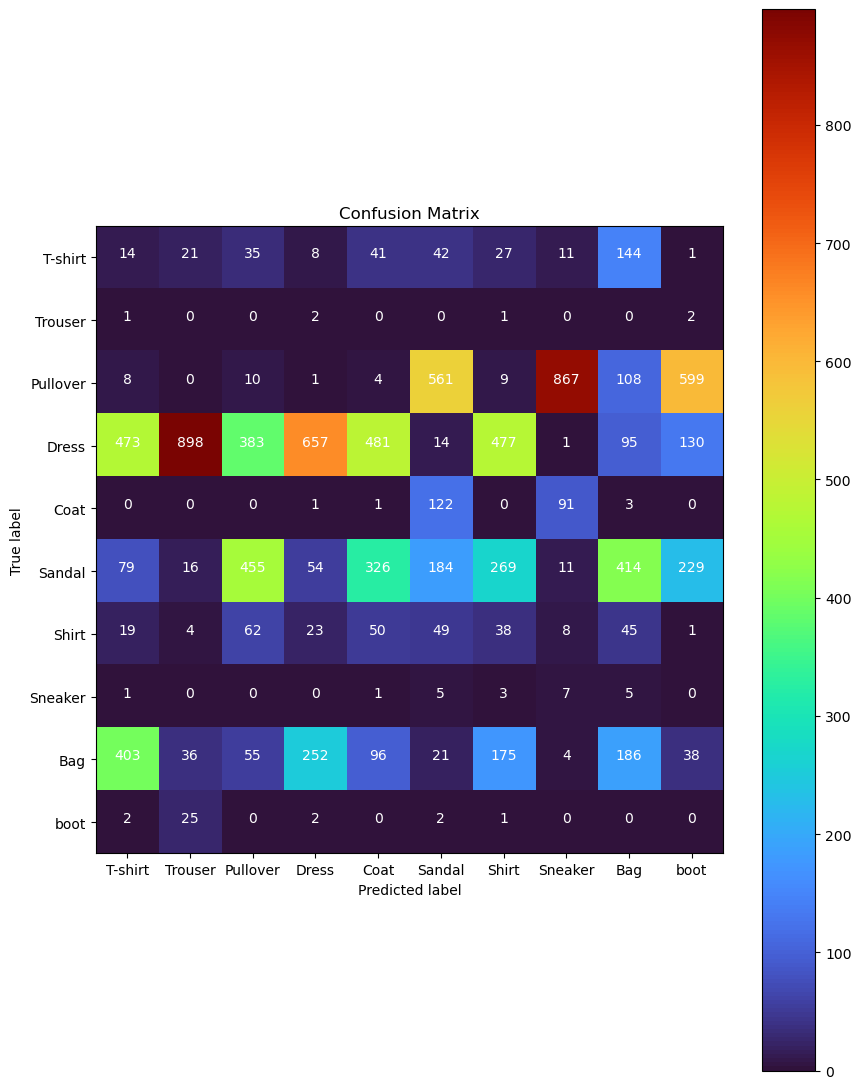

Accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▅▆▇▇█████
val_loss,█▄▃▂▂▁▁▁▁▁
Accuracy,96.78333
epoch,10
train_accuracy,98.87593
train_loss,0.03559
val_accuracy,96.78333


In [16]:
sweep_id = wandb.sweep(sweep_config, project = 'DL_assignment_1')
wandb.agent(sweep_id, main, count = 1)
wandb.finish()

In [5]:
import numpy as np


def sigmoid(z):
  g = 1/(1+np.exp(-z))
  return g

def tanh(z):
  g = np.tanh(z)
  return g

def relu(z):
  return np.maximum(0,z)

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def initialize(initializer, size1, size2):
  if(initializer == "random"):
     W = np.random.randn(size1, size2) * 0.01
     return W

  if(initializer == "Xavier"):
     W = np.random.randn(size1, size2) * np.sqrt(1/size2)
     return W

  print("Enter the name of initializer correctly")

def linear_forward(H, W, b):
  W = np.asarray(W)
  H = np.reshape(H,(H.shape[0],-1))
  A = np.dot(W,H) + b 
  cache = (H, W, b)
  
  return A, cache


def initialize_Wb_matrix(X, num_hidden, size_hidden, initializer):
  layer_dims = [X.shape[0]]
  for l in range(0, num_hidden):
    layer_dims.append(size_hidden)
  layer_dims.append(10)   
  np.random.seed(3)
  Wb_matrix = {}
  update = {}
  grads = {}
  L = len(layer_dims)            # number of layers in the network

  for l in range(1,L):
    Wb_matrix['W' + str(l)] = initialize(initializer, layer_dims[l], layer_dims[l-1])
    update['W' + str(l)] = np.zeros((layer_dims[l], layer_dims[l-1]))
    Wb_matrix['b' + str(l)] = np.zeros((layer_dims[l], 1))
    update['b' + str(l)] = np.zeros((layer_dims[l], 1))
    grads['dW' + str(l)] = np.zeros((layer_dims[l], layer_dims[l-1]))
    grads['db' + str(l)] = np.zeros((layer_dims[l], 1))
  return Wb_matrix, update, grads


def activation_forward(H_prev, W, b, activation):
  A, linear_cache = linear_forward(H_prev, W, b)
  activation_cache = A
  if activation == 'relu':
    H = relu(A)
  elif activation == 'sigmoid':
    H = sigmoid(A)
  elif activation =='tanh':
    H = tanh(A)
  elif activation == 'softmax':
    H = softmax(A)
  
  return H, activation_cache, linear_cache


def forward_propagation(X, Wb_matrix, activation):
    H = X
    L = int((len(Wb_matrix)/2))
    A_caches = []
    H_caches = [H]
    for l in range(1, L):
        H_prev = H 
        H, A_cache, linear_cache = activation_forward(H_prev, Wb_matrix['W{:d}'.format(l)], Wb_matrix['b{:d}'.format(l)], activation)
        A_caches.append(A_cache)
        H_caches.append(H)
    HL, AL, linear_cache = activation_forward(H, Wb_matrix['W%d' % L], Wb_matrix['b%d' % L], activation='softmax')
    A_caches.append(AL)
    H_caches.append(HL)
    return HL, H_caches, A_caches